# Cross-chunk indices

Our data are divided into 103 chunks. However, there is a group of morphometric characters which require immediate context. Which means that we need to access features from different chunks if we want to avoid edge effect cause by edges of our chunks.

This notebook ensures that each enclosed tessellation cell has its own unique identifier and for each chunk, extract indices of those, which needs to be accessed from other chunks.

Since the maximum topological distance on tessellation we use for measuring are 3 steps, we include all cells within 7 steps from the boundary. That should ensure that results are in no way skewed by our chunking.

In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

## Fill missing unique ids in enclosed tessellation

Cells with no building have no ID at the moment. Filling unique identifiers instead of NaNs.

In [90]:
%%time
for ch in range(103):
    tess = gpd.read_parquet(f'../../urbangrammar_samba/spatial_signatures/tessellation/tess_{int(ch)}.pq')
    tess = tess.reset_index(drop=True)
    filler = pd.Series(range(len(tess[tess.uID.isna()])), index=tess[tess.uID.isna()].index) + ch * 100_000_000
    tess['uID'] = tess.uID.fillna(filler)
    tess.to_parquet(f'../../urbangrammar_samba/spatial_signatures/tessellation/tess_{int(ch)}.pq')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  


CPU times: user 4min 23s, sys: 59.9 s, total: 5min 23s
Wall time: 7min 34s


## Store unique ids of close neighbors from other chunks

We first use `fuzzy_contiguity` to get all neighbouring chunks within 10km.

In [2]:
chunks = gpd.read_parquet('../../urbangrammar_samba/spatial_signatures/local_auth_chunks.pq')

In [3]:
from libpysal.weights import fuzzy_contiguity

w = fuzzy_contiguity(chunks, buffering=True, buffer=5_000)

<AxesSubplot:>

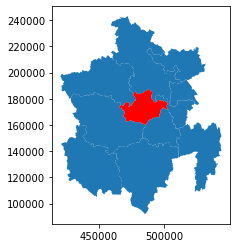

In [152]:
ax = chunks.loc[w.neighbors[2]].plot()
chunks.loc[[2]].plot(ax=ax, color='r')

Now we loop through all the chunks and their neighbors and extract indices of nearby tessellation cells within 7 topological steps.

In [126]:
%%time

include = pd.Series(index=pd.MultiIndex.from_tuples([], names=['chunk', 'neighbors']), dtype=object)

for ch in tqdm(range(103), total=103):
    target = chunks.loc[ch, 'geometry']

    for n in w.neighbors[ch]:
        tess = gpd.read_parquet(f'../../urbangrammar_samba/spatial_signatures/morphometrics/cells/cells_{int(n)}.pq')

        ind = tess.sindex.query(target, predicate='intersects')

        if ind.size > 0:
            incl = ind.tolist()
            for _ in range(6):
                inp, res = tess.sindex.query_bulk(tess.geometry.iloc[incl], predicate='intersects')
                incl += np.unique(res).tolist()
        else:
            incl = []
        include.loc[ch, int(n)] = np.unique(incl)


CPU times: user 30min 34s, sys: 4min 31s, total: 35min 6s
Wall time: 45min 58s


In [127]:
include

chunk  neighbors
0      44                                                          []
       63                                                          []
       18                                                          []
       20           [20262, 20263, 20265, 20266, 20268, 20269, 202...
       84                                                          []
                                          ...                        
102    17           [2, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17...
       101          [7164, 7165, 7166, 7181, 7182, 7183, 7184, 718...
       18                                                          []
       24                                                          []
       40                                                          []
Length: 874, dtype: object

And finally remove those which are empty (since we used buffered distance not Queen contiguity, there are some).

In [128]:
include = include[include.apply(lambda x: len(x) > 0)]

In [129]:
include

chunk  neighbors
0      20           [20262, 20263, 20265, 20266, 20268, 20269, 202...
1      7            [81225, 81250, 81255, 81256, 81258, 82455, 824...
       82           [130223, 130579, 130601, 130604, 130607, 13060...
       94           [80660, 81838, 81902, 81904, 81908, 81916, 819...
       21           [41989, 41991, 41992, 41996, 42904, 42907, 429...
                                          ...                        
102    74           [8403, 8404, 8405, 8406, 8407, 8415, 8417, 843...
       75           [37503, 37504, 37505, 37506, 37507, 37508, 375...
       70           [35, 38, 266, 267, 268, 269, 638, 639, 640, 64...
       17           [2, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17...
       101          [7164, 7165, 7166, 7181, 7182, 7183, 7184, 718...
Length: 504, dtype: object

In [151]:
pd.DataFrame(include, columns=['indices']).to_parquet('../../urbangrammar_samba/spatial_signatures/cross-chunk_indices.pq')

### Larger extent to cover 10 topological steps

Later we will also need to go furhter across chunks, so we get indices for 12 steps.

In [5]:
%%time

include = pd.Series(index=pd.MultiIndex.from_tuples([], names=['chunk', 'neighbors']), dtype=object)

for ch in tqdm(range(103), total=103):
    target = chunks.loc[ch, 'geometry']

    for n in w.neighbors[ch]:
        tess = gpd.read_parquet(f'../../urbangrammar_samba/spatial_signatures/morphometrics/cells/cells_{int(n)}.pq', columns=["tessellation"])

        ind = tess.sindex.query(target, predicate='intersects')

        if ind.size > 0:
            incl = ind.tolist()
            for _ in range(12):
                inp, res = tess.sindex.query_bulk(tess.geometry.iloc[incl], predicate='intersects')
                incl += np.unique(res).tolist()
        else:
            incl = []
        include.loc[ch, int(n)] = np.unique(incl)
        
include = include[include.apply(lambda x: len(x) > 0)]
pd.DataFrame(include, columns=['indices']).to_parquet('../../urbangrammar_samba/spatial_signatures/cross-chunk_indices_10.pq')

  0%|          | 0/103 [00:00<?, ?it/s]

CPU times: user 45min 53s, sys: 2min 30s, total: 48min 23s
Wall time: 1h 2min 50s
